In [1]:
import csv as csv 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import os
import time
import statsmodels.api as smdl
import pprint as pp
import re

from math import pi
from numpy import histogram
from numpy import histogram
from bokeh.layouts import row, column, gridplot
from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure
from bokeh.models.glyphs import MultiLine
from bokeh.models import ColumnDataSource
from bokeh.models import NumeralTickFormatter
from bokeh.models import HoverTool
from bokeh.palettes import Category20_20 as cat20
from sklearn import metrics
from scipy import stats
from scipy.cluster.vq import kmeans,vq
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from functools import reduce


output_notebook()

Loading BokehJS ...

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
#functions
def trimToIntersect(df, col_name, I):
    df = df[df[col_name].apply(lambda x: x in I)]
    return df

def getDRGCodes(df):
        codes = df['DRG Definition'].apply(lambda x: int(re.match('\d{3}', x).group(0)))
        return codes
    
def groupByState(df):
    #recover original values
    df['Total Charges'] = df['Total Discharges'] * df['Average Covered Charges']
    df['Total Payments'] = df['Total Discharges'] * df['Average Total Payments']
    df['Total Medicare Payments'] = df['Total Discharges'] * df['Average Medicare Payments']

    #group by DRG, take sums
    newdf = df.groupby(['Provider State']).agg({ 'Total Discharges':'sum',
                                              'Total Charges': 'sum',
                                              'Total Payments':'sum',
                                              'Total Medicare Payments': 'sum' })

    #calcuate new averages
    newdf['Average Charges'] = newdf['Total Charges']/newdf['Total Discharges']
    newdf['Average Payments'] = newdf['Total Payments']/newdf['Total Discharges']
    newdf['Average Medicare Payment'] = newdf['Total Medicare Payments']/newdf['Total Discharges']
    newdf['Average Non Medicare Payment'] = newdf['Average Payments'] - newdf['Average Medicare Payment']
    
    newdf.drop(columns=['Total Charges', 'Total Payments', 'Total Medicare Payments'], inplace=True)
    newdf = newdf.sort_values(by='Average Charges', ascending=False)
    
    return newdf

def groupByProvider(df_orig):
    #recover original values
    
    df = df_orig.copy()
    
    df['Total Charges'] = df['Total Discharges'] * df['Average Covered Charges']
    df['Total Payments'] = df['Total Discharges'] * df['Average Total Payments']
    df['Total Medicare Payments'] = df['Total Discharges'] * df['Average Medicare Payments']

    #group by , take sums
    newdf = df.groupby(['Provider Id']).agg({ 'Total Discharges':'sum',
                                              'Total Charges': 'sum',
                                              'Total Payments':'sum',
                                              'Total Medicare Payments': 'sum' })
  
    #calcuate new averages
    newdf['Average Charges'] = newdf['Total Charges']/newdf['Total Discharges']
    newdf['Average Payments'] = newdf['Total Payments']/newdf['Total Discharges']
    newdf['Average Medicare Payment'] = newdf['Total Medicare Payments']/newdf['Total Discharges']
    newdf['Average Non Medicare Payment'] = newdf['Average Payments'] - newdf['Average Medicare Payment']
    
    newdf.drop(columns=['Total Charges',
                     'Total Payments',
                     'Total Medicare Payments'], inplace=True)
    newdf = newdf.sort_values(by='Average Charges', ascending=False)
    

    return newdf

def groupByDRG(df):
    #recover original values
    df['Total Charges'] = df['Total Discharges'] * df['Average Covered Charges']
    df['Total Payments'] = df['Total Discharges'] * df['Average Total Payments']
    df['Total Medicare Payments'] = df['Total Discharges'] * df['Average Medicare Payments']

    #group by DRG, take sums
    newdf = df.groupby(['DRG Definition'], as_index=False).agg({ 'Total Discharges':'sum',
                                              'Total Charges': 'sum',
                                              'Total Payments':'sum',
                                              'Total Medicare Payments': 'sum' })

    #calcuate new averages
    newdf['Average Charges'] = newdf['Total Charges']/newdf['Total Discharges']
    newdf['Average Payments'] = newdf['Total Payments']/newdf['Total Discharges']
    newdf['Average Medicare Payment'] = newdf['Total Medicare Payments']/newdf['Total Discharges']
    newdf['Average Non Medicare Payment'] = newdf['Average Payments'] - newdf['Average Medicare Payment']
    
    newdf['DRG Code'] = getDRGCodes(newdf)
    newdf.drop(columns=['Total Charges', 'Total Payments', 'Total Medicare Payments'], inplace=True)
    newdf = newdf.sort_values(by='Average Charges', ascending=False)
    
    return newdf

def addYearToCols(df, year):
    df = df.rename(columns={"Total Discharges": "Total Discharges-" + str(year),
                            "Average Charges": "Average Charges-" + str(year),
                            "Average Payments" : "Average Payments-" + str(year),
                            "Average Medicare Payment": "Average Medicare Payment-" + str(year),
                            "Average Non Medicare Payment": "Average Non Medicare Payment-" + str(year)})
    return df

def getYValues(df, colName):
    
    ydata = []  
    for index, row in df.iterrows():
    
        fin_data = [ row[colName + "-2011"],
                     row[colName + "-2012"],
                     row[colName + "-2013"],
                     row[colName + "-2014"],
                     row[colName + "-2015"],
                     row[colName + "-2016"]]

        ydata.append(fin_data)
        
    return ydata


def getLabelValues(df, label):
    l = []
    for index, row in df.iterrows():
        l.append(row[label])
    return l


YRS = [ 2011, 2012, 2013, 2014, 2015, 2016]


In [4]:
file2011='Medicare_Provider_Charge_Inpatient_DRG100_FY2011.csv'
file2012='Medicare_Provider_Charge_Inpatient_DRG100_FY2012.csv'
file2013='Medicare_Provider_Charge_Inpatient_DRG100_FY2013.csv'
file2014='Medicare_Provider_Charge_Inpatient_DRGALL_FY2014.csv'
file2015='Medicare_Provider_Charge_Inpatient_DRGALL_FY2015.csv'
file2016='Medicare_Provider_Charge_Inpatient_DRGALL_FY2016.csv'


df2011 = pd.read_csv(file2011)
df2012 = pd.read_csv(file2012)
df2013 = pd.read_csv(file2013)
df2014 = pd.read_csv(file2014)
df2015 = pd.read_csv(file2015)
df2016 = pd.read_csv(file2016)


#some empty rows in file
df2013 = df2013.dropna()
df2013.isnull().values.any()

#remove special chars
messy_cols = ['Total Discharges','Average Covered Charges', 'Average Total Payments', 'Average Medicare Payments']
df2016[messy_cols] = df2016[messy_cols].replace({'\$': '', ',': ''}, regex=True)
df2016[messy_cols] = df2016[messy_cols].astype(np.float64)


/home/mai/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
print(df2011.shape)
print(df2012.shape)
print(df2013.shape)
print(df2014.shape)
print(df2015.shape)
print(df2016.shape)

(163065, 12)
(157747, 12)
(153600, 12)
(202656, 12)
(201876, 12)
(197283, 12)


In [6]:
df2016.head()

DRG Definition  Provider Id  \
0  001 - HEART TRANSPLANT OR IMPLANT OF HEART ASS...        10033   
1  001 - HEART TRANSPLANT OR IMPLANT OF HEART ASS...        30103   
2  001 - HEART TRANSPLANT OR IMPLANT OF HEART ASS...        40114   
3  001 - HEART TRANSPLANT OR IMPLANT OF HEART ASS...        50025   
4  001 - HEART TRANSPLANT OR IMPLANT OF HEART ASS...        50100   

                                       Provider Name  \
0                     UNIVERSITY OF ALABAMA HOSPITAL   
1                               MAYO CLINIC HOSPITAL   
2          BAPTIST HEALTH MEDICAL CENTER-LITTLE ROCK   
3  UC SAN DIEGO HEALTH HILLCREST - HILLCREST MED CTR   
4                            SHARP MEMORIAL HOSPITAL   

       Provider Street Address Provider City Provider State  \
0        619 SOUTH 19TH STREET    BIRMINGHAM             AL   
1     5777 EAST MAYO BOULEVARD       PHOENIX             AZ   
2  9601 INTERSTATE 630, EXIT 7   LITTLE ROCK             AR   
3         200 WEST ARBOR DRIVE     SAN DIEGO             CA   
4                7901 FROST ST     SAN DIEGO             CA   

   Provider Zip Code Hospital Referral Region (HRR) Description  \
0              35233                            AL - Birmingham   
1              85054                               AZ - Phoenix   
2              72205                           AR - Little Rock   
3              92103                             CA - San Diego   
4              92123                             CA - San Diego   

   Total Discharges  Average Covered Charges  Average Total Payments  \
0              13.0               1016806.46               296937.00   
1              26.0                443387.54               215059.54   
2              33.0                711472.00               180315.55   
3              17.0                796343.82               299244.41   
4              13.0               1434651.46               239537.46   

   Average Medicare Payments  
0                  150139.69  
1                  163889.31  
2                  145192.61  
3                  270131.59  
4                  215205.00

## Group By State

In [7]:
#group by DRG
grpstate2011 = groupByState(df2011)
grpstate2012 = groupByState(df2012)
grpstate2013 = groupByState(df2013)
grpstate2014 = groupByState(df2014)
grpstate2015 = groupByState(df2015)
grpstate2016 = groupByState(df2016)

In [31]:
grpstate2016.head()

Total Discharges-2016  Average Charges-2016  \
Provider State                                                
CA                           510698.0          97703.841476   
NV                            51612.0          90526.355029   
AK                             7198.0          83987.403381   
NJ                           259507.0          81603.720481   
DC                            26371.0          72298.653070   

                Average Payments-2016  Average Medicare Payment-2016  \
Provider State                                                         
CA                       17102.117789                   15066.745890   
NV                       13736.296223                   11793.100002   
AK                       20204.733486                   17922.410842   
NJ                       13419.856674                   11448.838145   
DC                       19389.183886                   15231.270443   

                Average Non Medicare Payment-2016  
Provider State                                     
CA                                    2035.371900  
NV                                    1943.196221  
AK                                    2282.322644  
NJ                                    1971.018529  
DC                                    4157.913442

In [9]:
# add year to column to avoid overwriting when merging
grpstate2011 = addYearToCols(grpstate2011, 2011)
grpstate2012 = addYearToCols(grpstate2012, 2012)
grpstate2013 = addYearToCols(grpstate2013, 2013)
grpstate2014 = addYearToCols(grpstate2014, 2014)
grpstate2015 = addYearToCols(grpstate2015, 2015)
grpstate2016 = addYearToCols(grpstate2016, 2016)

In [10]:
grpstate2016.head()

Total Discharges-2016  Average Charges-2016  \
Provider State                                                
CA                           510698.0          97703.841476   
NV                            51612.0          90526.355029   
AK                             7198.0          83987.403381   
NJ                           259507.0          81603.720481   
DC                            26371.0          72298.653070   

                Average Payments-2016  Average Medicare Payment-2016  \
Provider State                                                         
CA                       17102.117789                   15066.745890   
NV                       13736.296223                   11793.100002   
AK                       20204.733486                   17922.410842   
NJ                       13419.856674                   11448.838145   
DC                       19389.183886                   15231.270443   

                Average Non Medicare Payment-2016  
Provider State                                     
CA                                    2035.371900  
NV                                    1943.196221  
AK                                    2282.322644  
NJ                                    1971.018529  
DC                                    4157.913442

In [11]:
#merge into dataframe
dfs = [grpstate2011, grpstate2012, grpstate2013, grpstate2014, grpstate2015, grpstate2016 ]
states_merged = reduce(lambda  left,right: pd.merge(left,right, right_index=True, left_index=True), dfs )
states_merged.head()

Total Discharges-2011  Average Charges-2011  \
Provider State                                                
CA                             474979          66541.577095   
NJ                             251207          60899.983902   
NV                              42600          58252.526667   
AK                               6142          42951.970369   
FL                             536859          42743.798221   

                Average Payments-2011  Average Medicare Payment-2011  \
Provider State                                                         
CA                       12342.049790                   11189.282612   
NJ                        9801.035811                    8732.428428   
NV                        9998.099883                    8415.740446   
AK                       14677.612341                   12863.925106   
FL                        8381.873153                    7199.954487   

                Average Non Medicare Payment-2011  Total Discharges-2012  \
Provider State                                                             
CA                                    1152.767177                 459424   
NJ                                    1068.607384                 232026   
NV                                    1582.359437                  40543   
AK                                    1813.687236                   6091   
FL                                    1181.918666                 512716   

                Average Charges-2012  Average Payments-2012  \
Provider State                                                
CA                      70516.130394           12947.039981   
NJ                      63618.362597           10094.748295   
NV                      62815.528031           10437.553881   
AK                      47420.611394           14478.948613   
FL                      45549.198342            8553.855316   

                Average Medicare Payment-2012  \
Provider State                                  
CA                               11745.363348   
NJ                                8969.942912   
NV                                8865.587401   
AK                               12782.795272   
FL                                7320.387616   

                Average Non Medicare Payment-2012  \
Provider State                                      
CA                                    1201.676632   
NJ                                    1124.805384   
NV                                    1571.966480   
AK                                    1696.153341   
FL                                    1233.467700   

                              ...                  Total Discharges-2015  \
Provider State                ...                                          
CA                            ...                                 503269   
NJ                            ...                                 265786   
NV                            ...                                  49853   
AK                            ...                                   7014   
FL                            ...                                 607658   

                Average Charges-2015  Average Payments-2015  \
Provider State                                                
CA                      92726.447013           16202.850641   
NJ                      80059.060888           12883.408961   
NV                      83942.720681           13317.789519   
AK                      73853.672169           18505.172409   
FL                      60454.840192           10352.462227   

                Average Medicare Payment-2015  \
Provider State                                  
CA                               14297.788762   
NJ                               10969.269132   
NV                               11419.332209   
AK                               16362.207136   
FL                                8750.112225   

                Average Non Medicare Payment-2015  Total Di

In [12]:
from bokeh.layouts import gridplot
from bokeh.palettes import Category20b_20 as catb20
from bokeh.palettes import Category20c_20 as catc20


x = [YRS] * len(states_merged)
y1 =  getYValues(states_merged, "Average Charges")
y2 =  getYValues(states_merged, "Average Payments")
y3 =  getYValues(states_merged, "Average Medicare Payment")
y4 =  getYValues(states_merged, "Average Non Medicare Payment")
y5 =  getYValues(states_merged, "Total Discharges")

crs = np.random.choice(cat20, len(states_merged))
states = states_merged.index



source = ColumnDataSource(dict(
        xs=x,
        ys1=y1,
        ys2=y2,
        ys3=y3,
        ys4=y4,
        ys5=y5,
        sts=states,
        colors=crs
    )
)

tt = [('State', '@sts')]

p1 = figure( title="Average Charges", background_fill_color='whitesmoke')
p1.multi_line(xs='xs', ys='ys1', source=source, line_width=4, line_alpha=0.4, hover_line_color='black', line_color='colors')
p1.add_tools(HoverTool(show_arrow=False, line_policy='next', tooltips=tt))
p1.left[0].formatter.use_scientific = False

p2 = figure( title="Average Payments", background_fill_color='whitesmoke')
p2.multi_line(xs='xs', ys='ys2', source=source, line_width=4, line_alpha=0.4, hover_line_color='black', line_color='colors')
p2.add_tools(HoverTool(show_arrow=False, line_policy='next', tooltips=tt))

p3 = figure( title="Average Medicare Payment", background_fill_color='whitesmoke')
p3.multi_line(xs='xs', ys='ys3', source=source, line_width=4, line_alpha=0.4, hover_line_color='black', line_color='colors')
p3.add_tools(HoverTool(show_arrow=False, line_policy='next', tooltips=tt))

p4 = figure( title="Average Non Medicare Payment", background_fill_color='whitesmoke')
p4.multi_line(xs='xs', ys='ys4', source=source, line_width=4, line_alpha=0.4, hover_line_color='black', line_color='colors')
p4.add_tools(HoverTool(show_arrow=False, line_policy='next', tooltips=tt))

p5 = figure( title="Total Discharges", background_fill_color='whitesmoke')
p5.multi_line(xs='xs', ys='ys5', source=source, line_width=4, line_alpha=0.4, hover_line_color='black', line_color='colors')
p5.add_tools(HoverTool(show_arrow=False, line_policy='next', tooltips=tt))
p5.left[0].formatter.use_scientific = False

grid = gridplot([[p1, p2, p5], [p3, p4, None]])
show(grid)

## Grouping By DRG

In [32]:
df2011['DRG Code'] = getDRGCodes(df2011)
df2012['DRG Code'] = getDRGCodes(df2012)
df2013['DRG Code'] = getDRGCodes(df2013)
df2014['DRG Code'] = getDRGCodes(df2014)
df2015['DRG Code'] = getDRGCodes(df2015)
df2016['DRG Code'] = getDRGCodes(df2016)

codes2011 = df2011['DRG Code'].unique()
codes2012 = df2012['DRG Code'].unique()
codes2013 = df2013['DRG Code'].unique()
codes2014 = df2014['DRG Code'].unique()
codes2015 = df2015['DRG Code'].unique()
codes2016 = df2016['DRG Code'].unique()

#get intersection of DRG Codes
I = reduce(np.intersect1d, (codes2011, codes2012, codes2013, codes2014, codes2015, codes2016))

## remove DRGs not with intersection
drg2011 = trimToIntersect(df2011, 'DRG Code', I)
drg2012 = trimToIntersect(df2012, 'DRG Code', I)
drg2013 = trimToIntersect(df2013, 'DRG Code', I)
drg2014 = trimToIntersect(df2014, 'DRG Code', I)
drg2015 = trimToIntersect(df2015, 'DRG Code', I)
drg2016 = trimToIntersect(df2016, 'DRG Code', I)

In [33]:
#group by DRG
grpDRG2011 = groupByDRG(drg2011)
grpDRG2012 = groupByDRG(drg2012)
grpDRG2013 = groupByDRG(drg2013)
grpDRG2014 = groupByDRG(drg2014)
grpDRG2015 = groupByDRG(drg2015)
grpDRG2016 = groupByDRG(drg2016)

/home/mai/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/mai/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/mai/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/index

In [34]:
# add year to column to avoid overwriting when merging
grpDRG2011 = addYearToCols(grpDRG2011, 2011)
grpDRG2012 = addYearToCols(grpDRG2012, 2012)
grpDRG2013 = addYearToCols(grpDRG2013, 2013)
grpDRG2014 = addYearToCols(grpDRG2014, 2014)
grpDRG2015 = addYearToCols(grpDRG2015, 2015)
grpDRG2016 = addYearToCols(grpDRG2016, 2016)

In [35]:
#merge into dataframe
dfs = [grpDRG2011, grpDRG2012, grpDRG2013, grpDRG2014, grpDRG2015, grpDRG2016 ]
drg_merged = reduce(lambda  left,right: pd.merge(left,right, on='DRG Code'), dfs )

#clean up merged columns
dup_cols = drg_merged['DRG Definition_x']
drg_merged['DRG Definition'] = dup_cols.iloc[:,0]
drg_merged.drop(columns=['DRG Definition_x', 'DRG Definition_y'], inplace=True)
drg_merged


Total Discharges-2011  Average Charges-2011  Average Payments-2011  \
0                   22624         163325.924727           45800.304897   
1                   26412         143768.966115           39075.223118   
2                   39482         141995.086546           41267.558178   
3                   37250         135584.770120           38262.291436   
4                   27104          93363.315895           23336.481921   
5                   65997          92884.270225           27347.608649   
6                   34222          84391.353866           23389.605020   
7                   18714          79518.005077           22350.119429   
8                   17851          74927.733741           20972.504285   
9                   36434          68656.565159           17657.076549   
10                  29646          67968.686804           18181.944377   
11                  50766          65481.843615           18239.712879   
12                  28583          65054.383480           13877.647413   
13                  68080          62710.196842           16407.986017   
14                 108272          61985.034007           14292.068300   
15                  21820          61115.131897           15560.630614   
16                  27951          53134.335301           13990.301027   
17                  23834          52934.927834           14400.059872   
18                  66660          51383.269607           13857.547315   
19                  62093          50511.485981           13773.065869   
20                 427207          50105.260780           14324.484035   
21                  51079          49438.290902           13909.480608   
22                 319072          49418.600159           13650.959467   
23                  77525          48304.420884           12588.735556   
24                  18227          48091.444451           11518.103308   
25                  48398          46459.449729           12730.230898   
26                  26385          46399.256888           11668.784461   
27                  63934          46373.314262           12661.111944   
28                  22085          42212.746570           12369.462440   
29                 101029          40258.705372           11683.246751   
..                    ...                   ...                    ...   
63                  55849          23864.610468            5787.118068   
64                  32086          23776.084523            6082.141432   
65                  21596          23000.158455            5539.060937   
66                  63116          22808.392024            5841.400485   
67                  48854          22428.108261            5798.661031   
68                  48025          21892.232650            6069.980760   
69                  79590          21830.054705            5074.530142   
70                 102484          21461.879581            5849.762626   
71                  92851          20855.350648            5738.285210   
72                 141918          20541.310806            5156.213271   
73                 244854          20321.546816            5097.075817   
74                 140894          20272.376255            5887.524316   
75                 206695          19865.560768            5409.828549   
76                  20278          19464.267876            5171.738041   
77                  33393          18974.565897            5030.734196   
78                  89733          18761.074766            7180.196683   
79                  50411          18739.868620            4946.972347   
80                 114790          18120.848210            4936.957671   
81                  79873          18077.543851            4830.268188   
82                  22728          17837.788983            4821.377772   
83                 153660          17836.171899            4878.886301   
84                  25205          17734.803610            4485.602539   
85      

In [36]:
x = [YRS] * len(drg_merged)
y1 =  getYValues(drg_merged, "Average Charges")
y2 =  getYValues(drg_merged, "Average Payments")
y3 =  getYValues(drg_merged, "Average Medicare Payment")
y4 =  getYValues(drg_merged, "Average Non Medicare Payment")
y5 =  getYValues(drg_merged, "Total Discharges")

crs = np.random.choice(cat20, len(drg_merged))
drgs_list = getLabelValues(drg_merged, "DRG Definition")


source = ColumnDataSource(dict(
        xs=x,
        ys1=y1,
        ys2=y2,
        ys3=y3,
        ys4=y4,
        ys5=y5,
        drgs=drgs_list,
        colors=crs
    )
)

tt = [('DRG', '@drgs')]

p1 = figure( title="Average Charges", background_fill_color='whitesmoke')
p1.multi_line(xs='xs', ys='ys1', source=source, line_width=4, line_alpha=0.4, hover_line_color='black', line_color='colors')
p1.add_tools(HoverTool(show_arrow=False, line_policy='next', tooltips=tt))
p1.left[0].formatter.use_scientific = False

p2 = figure( title="Average Payments", background_fill_color='whitesmoke')
p2.multi_line(xs='xs', ys='ys2', source=source, line_width=4, line_alpha=0.4, hover_line_color='black', line_color='colors')
p2.add_tools(HoverTool(show_arrow=False, line_policy='next', tooltips=tt))

p3 = figure( title="Average Medicare Payment", background_fill_color='whitesmoke')
p3.multi_line(xs='xs', ys='ys3', source=source, line_width=4, line_alpha=0.4, hover_line_color='black', line_color='colors')
p3.add_tools(HoverTool(show_arrow=False, line_policy='next', tooltips=tt))

p4 = figure( title="Average Non Medicare Payment", background_fill_color='whitesmoke')
p4.multi_line(xs='xs', ys='ys4', source=source, line_width=4, line_alpha=0.4, hover_line_color='black', line_color='colors')
p4.add_tools(HoverTool(show_arrow=False, line_policy='next', tooltips=tt))

p5 = figure( title="Total Discharges", background_fill_color='whitesmoke')
p5.multi_line(xs='xs', ys='ys5', source=source, line_width=4, line_alpha=0.4, hover_line_color='black', line_color='colors')
p5.add_tools(HoverTool(show_arrow=False, line_policy='next', tooltips=tt))
p5.left[0].formatter.use_scientific = False

grid = gridplot([[p1, p2, p5], [p3, p4, None]])
show(grid)

In [37]:
#create long form for  quick seaborn plotting
drg_long = pd.wide_to_long(drg_merged, ['Total Discharges',
                                       'Average Charges',
                                       'Average Payments',
                                       'Average Medicare Payment',
                                       'Average Non Medicare Payment'], i='DRG Code', j='Year', sep='-')
drg_long = drg_long.reset_index(level=['Year'])
drg_long.head()

Year                                     DRG Definition  \
DRG Code                                                            
870       2011   870 - SEPTICEMIA OR SEVERE SEPSIS W MV 96+ HOURS   
207       2011  207 - RESPIRATORY SYSTEM DIAGNOSIS W VENTILATO...   
853       2011  853 - INFECTIOUS & PARASITIC DISEASES W O.R. P...   
329       2011   329 - MAJOR SMALL & LARGE BOWEL PROCEDURES W MCC   
246       2011  246 - PERC CARDIOVASC PROC W DRUG-ELUTING STEN...   

          Total Discharges  Average Charges  Average Payments  \
DRG Code                                                        
870                22624.0    163325.924727      45800.304897   
207                26412.0    143768.966115      39075.223118   
853                39482.0    141995.086546      41267.558178   
329                37250.0    135584.770120      38262.291436   
246                27104.0     93363.315895      23336.481921   

          Average Medicare Payment  Average Non Medicare Payment  
DRG Code                                                          
870                   43333.538057                   2466.766841  
207                   36451.729214                   2623.493904  
853                   38666.858923                   2600.699255  
329                   35824.353154                   2437.938282  
246                   21091.227568                   2245.254353

## Clustering of DRGs

In [38]:
drg_merged = drg_merged.set_index('DRG Code')
drg_num_cols = drg_merged[['Total Discharges-2011', 'Average Charges-2011',
       'Average Payments-2011', 'Average Medicare Payment-2011',
       'Average Non Medicare Payment-2011', 'Total Discharges-2012',
       'Average Charges-2012', 'Average Payments-2012',
       'Average Medicare Payment-2012', 'Average Non Medicare Payment-2012',
       'Total Discharges-2013', 'Average Charges-2013',
       'Average Payments-2013', 'Average Medicare Payment-2013',
       'Average Non Medicare Payment-2013', 'Total Discharges-2014',
       'Average Charges-2014', 'Average Payments-2014',
       'Average Medicare Payment-2014', 'Average Non Medicare Payment-2014',
       'Total Discharges-2015', 'Average Charges-2015',
       'Average Payments-2015', 'Average Medicare Payment-2015',
       'Average Non Medicare Payment-2015', 'Total Discharges-2016',
       'Average Charges-2016', 'Average Payments-2016',
       'Average Medicare Payment-2016', 'Average Non Medicare Payment-2016']]
drg_num_cols.head()

Total Discharges-2011  Average Charges-2011  Average Payments-2011  \
DRG Code                                                                       
870                       22624         163325.924727           45800.304897   
207                       26412         143768.966115           39075.223118   
853                       39482         141995.086546           41267.558178   
329                       37250         135584.770120           38262.291436   
246                       27104          93363.315895           23336.481921   

          Average Medicare Payment-2011  Average Non Medicare Payment-2011  \
DRG Code                                                                     
870                        43333.538057                        2466.766841   
207                        36451.729214                        2623.493904   
853                        38666.858923                        2600.699255   
329                        35824.353154                        2437.938282   
246                        21091.227568                        2245.254353   

          Total Discharges-2012  Average Charges-2012  Average Payments-2012  \
DRG Code                                                                       
870                       23862         169652.961739           46278.777722   
207                       23202         146400.348892           39734.457331   
853                       42769         147697.341696           41767.355444   
329                       35229         139050.431861           39022.121434   
246                       27175          97625.510802           23635.874811   

          Average Medicare Payment-2012  Average Non Medicare Payment-2012  \
DRG Code                                                                     
870                        43833.074093                        2445.703629   
207                        37165.940178                        2568.517154   
853                        39032.291029                        2735.064416   
329                        36350.132902                        2671.988532   
246                        21372.578362                        2263.296449   

                        ...                  Total Discharges-2015  \
DRG Code                ...                                          
870                     ...                                  30390   
207                     ...                                  19174   
853                     ...                                  62551   
329                     ...                                  29982   
246                     ...                                  32157   

          Average Charges-2015  Average Payments-2015  \
DRG Code                                                
870              188014.144973           44271.806112   
207              164296.326093           38629.288443   
853              156668.332350           38780.526513   
329              150743.259837           37046.446632   
246              116736.163270           24102.553563   

          Average Medicare Payment-2015  Average Non Medicare Payment-2015  \
DRG Code                                                                     
870                        40222.168789                        4049.637323   
207                        34705.954315                        3923.334129   
853                        34908.094198                        3872.432315   
329                        33217.680400                        3828.766232   
246                        21234.324320                        2868.229243   

          Total Discharges-2016  Average Charges-2016  Average Payments-2016  \
DRG Code                                                                       
870                     25139.0         194547.917753           44552.476853   
207                     13540.0         172306.417456           39711.158855   
853                     88073.0     

In [39]:


p1 = figure( plot_height=250, plot_width=250, title="Charges")
hist, edges = histogram(drg_merged['Average Charges-2016'], density=True, bins=20)
p1.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:], alpha=0.4)

p2 = figure( plot_height=250, plot_width=250, title="Payments")
hist, edges = histogram(drg_merged['Average Payments-2016'], density=True, bins=20)
p2.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:], alpha=0.4)

p3 = figure( plot_height=250, plot_width=250, title="Medicare Payments")
hist, edges = histogram(drg_merged['Average Medicare Payment-2016'], density=True, bins=20)
p3.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:], alpha=0.4)

p4 = figure( plot_height=250, plot_width=250, title="Non Medicare Payment")
hist, edges = histogram(drg_merged['Average Non Medicare Payment-2016'], density=True, bins=20)
p4.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:], alpha=0.4)


p5 = figure( plot_height=250, plot_width=250, title="Discharges")
hist, edges = histogram(drg_merged['Total Discharges-2016'], density=True, bins=20)
p5.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:], alpha=0.4)

show(row(p1, p2, p3, p4, p5))


In [40]:
norm_data = drg_num_cols.apply(np.log)
norm_data.head()

Total Discharges-2011  Average Charges-2011  Average Payments-2011  \
DRG Code                                                                       
870                   10.026767             12.003503              10.732046   
207                   10.181574             11.875963              10.573244   
853                   10.583600             11.863548              10.627832   
329                   10.525407             11.817352              10.552220   
246                   10.207437             11.444254              10.057773   

          Average Medicare Payment-2011  Average Non Medicare Payment-2011  \
DRG Code                                                                     
870                           10.676682                           7.810664   
207                           10.503744                           7.872262   
853                           10.562738                           7.863536   
329                           10.486383                           7.798908   
246                            9.956612                           7.716574   

          Total Discharges-2012  Average Charges-2012  Average Payments-2012  \
DRG Code                                                                       
870                   10.080043             12.041510              10.742439   
207                   10.051994             11.894100              10.589974   
853                   10.663569             11.902920              10.639870   
329                   10.469625             11.842592              10.571884   
246                   10.210053             11.488894              10.070521   

          Average Medicare Payment-2012  Average Non Medicare Payment-2012  \
DRG Code                                                                     
870                           10.688144                           7.802088   
207                           10.523148                           7.851084   
853                           10.572145                           7.913910   
329                           10.500953                           7.890578   
246                            9.969864                           7.724578   

                        ...                  Total Discharges-2015  \
DRG Code                ...                                          
870                     ...                              10.321869   
207                     ...                               9.861310   
853                     ...                              11.043738   
329                     ...                              10.308352   
246                     ...                              10.378385   

          Average Charges-2015  Average Payments-2015  \
DRG Code                                                
870                  12.144272              10.698103   
207                  12.009427              10.561766   
853                  11.961886              10.565674   
329                  11.923333              10.519928   
246                  11.667672              10.090073   

          Average Medicare Payment-2015  Average Non Medicare Payment-2015  \
DRG Code                                                                     
870                           10.602174                           8.306383   
207                           10.454667                           8.274697   
853                           10.460474                           8.261638   
329                           10.410838                           8.250298   
246                            9.963374                           7.961450   

          Total Discharges-2016  Average Charges-2016  Average Payments-2016  \
DRG Code                                                                       
870                   10.132176             12.178434              10.704423   
207                    9.513404             12.057030              10.589388   
853                   11.385921     

In [41]:
#KMeans 

df_norm = norm_data
df_orig = drg_merged
kmeansModel = KMeans(init='random', n_clusters=4, n_init=10)
kmeansModel.fit_predict(df_norm)
clusterIDs = kmeansModel.labels_


pca = PCA(n_components=2)
pca.fit(df_norm)
pca_pairs = pca.transform(df_norm)

[xpos,ypos] = [0,1]

clus1 = ColumnDataSource(dict(x=pca_pairs[clusterIDs==0,xpos], 
     y=pca_pairs[clusterIDs==0,ypos],
     drg=np.array(df_orig[clusterIDs==0]['DRG Definition'])))
clus2 = ColumnDataSource(dict(x=pca_pairs[clusterIDs==1,xpos], 
     y=pca_pairs[clusterIDs==1,ypos],
     drg=np.array(df_orig[clusterIDs==1]['DRG Definition'])))
clus3 = ColumnDataSource(dict(x=pca_pairs[clusterIDs==2,xpos], 
     y=pca_pairs[clusterIDs==2,ypos],
     drg=np.array(df_orig[clusterIDs==2]['DRG Definition'])))
clus4 = ColumnDataSource(dict(x=pca_pairs[clusterIDs==3,xpos], 
     y=pca_pairs[clusterIDs==3,ypos],
     drg=np.array(df_orig[clusterIDs==3]['DRG Definition'])))   
                                                              

TOOLTIPS = [("DRG", "@drg") ]
p = figure(plot_width=900, plot_height=600, title="Kmeans Clustering k=4", toolbar_location="below", tooltips=TOOLTIPS)
p.circle( x='x', y = 'y', source=clus1, size=9, color="gold")
p.circle( x='x', y = 'y', source=clus2, size=9, color="crimson")
p.circle( x='x', y = 'y', source=clus3, size=9, color="navy")
p.circle( x='x', y = 'y', source=clus4, size=9, color="palegreen")
p.xaxis.axis_label = 'PCA 1'
p.yaxis.axis_label = 'PCA 2'

show(p)

print("Silhouette Score: ", metrics.silhouette_score(norm_data, clusterIDs, metric='euclidean'))
print("PCA Explained Variance Ratio: " , pca.explained_variance_ratio_)

Silhouette Score:  0.36659823542260167
PCA Explained Variance Ratio:  [0.60175917 0.36477219]


Text(33.0, 0.5, 'Num Clusters k')

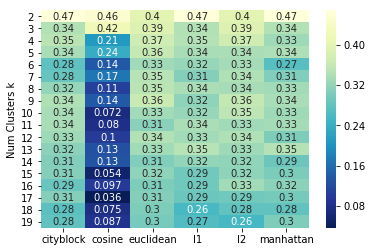

In [42]:
# Grid Search
num_clusters = range(2, 20)
dist_measures = ['cityblock', 'cosine', 'euclidean', 'l1', 'l2', 'manhattan']
grid_search = pd.DataFrame(columns=dist_measures, index=num_clusters)

for i, num in enumerate(num_clusters):
    for j, measure in enumerate(dist_measures):

        kmeansModel = KMeans(init='random', n_clusters=num, n_init=10)
        kmeansModel.fit_predict(norm_data)
        clusterIDs = kmeansModel.labels_
        
        score = metrics.silhouette_score(norm_data, clusterIDs, metric=measure)
        
        grid_search.iloc[i, j] = score

grid_search = grid_search.astype(float)
sns.heatmap(grid_search, annot=True, cmap="YlGnBu_r")
plt.ylabel('Num Clusters k')



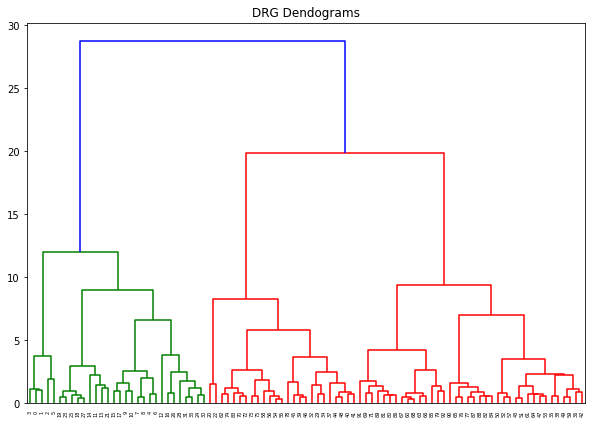

In [36]:
import scipy.cluster.hierarchy as shc

plt.figure(figsize=(10, 7))  
plt.title("DRG Dendograms")  
dend = shc.dendrogram(shc.linkage(norm_data, method='ward'))  

## Group By Provider

In [45]:
# get provider ids
pvdrs2011 = df2011['Provider Id'].unique()
pvdrs2012 = df2012['Provider Id'].unique()
pvdrs2013 = df2013['Provider Id'].unique()
pvdrs2014 = df2014['Provider Id'].unique()
pvdrs2015 = df2015['Provider Id'].unique()
pvdrs2016 = df2016['Provider Id'].unique()

#get intersection of provider ids
common_providers = reduce(np.intersect1d, (pvdrs2011, pvdrs2012, pvdrs2013, pvdrs2014, pvdrs2015, pvdrs2016))


#trim dataframes down
d2011 = trimToIntersect(df2011, 'Provider Id', common_providers)
d2012 = trimToIntersect(df2012, 'Provider Id', common_providers)
d2013 = trimToIntersect(df2013, 'Provider Id', common_providers)
d2014 = trimToIntersect(df2014, 'Provider Id', common_providers)
d2015 = trimToIntersect(df2015, 'Provider Id', common_providers)
d2016 = trimToIntersect(df2016, 'Provider Id', common_providers)

In [46]:
#group values by provider, but provider info is lost, will need to remerge
grpHP2011 = groupByProvider(d2011)
grpHP2012 = groupByProvider(d2012)
grpHP2013 = groupByProvider(d2013)
grpHP2014 = groupByProvider(d2014)
grpHP2015 = groupByProvider(d2015)
grpHP2016 = groupByProvider(d2016)


In [47]:
#add year for merging 
grpHP2011 = addYearToCols(grpHP2011, 2011)
grpHP2012 = addYearToCols(grpHP2012, 2012)
grpHP2013 = addYearToCols(grpHP2013, 2013)
grpHP2014 = addYearToCols(grpHP2014, 2014)
grpHP2015 = addYearToCols(grpHP2015, 2015)
grpHP2016 = addYearToCols(grpHP2016, 2016)

In [56]:
#merge into one providers data set, but is missing provider info
dfs = [grpHP2011, grpHP2012, grpHP2013, grpHP2014, grpHP2015, grpHP2016 ]
providers_merged_int = reduce(lambda  left,right: pd.merge(left,right, left_index=True, right_index=True), dfs )
print(providers_merged_int.shape)
print("Num Providers: ", len(providers_merged_int.index.unique()))

(3071, 30)
Num Providers:  3071


In [57]:
#Get Providers DataFrames
def getDFFromGroupObject(groupObj):
    uniq_rows = []
    cnames = []

    for i,group in groupObj:
        uniq_rows.append(np.array(group.iloc[0]))
        if len(cnames) == 0:
            cnames = group.iloc[0].index.values
            
    providers = pd.DataFrame(data=uniq_rows, columns=cnames)
    #providers = providers.set_index('Provider Id')
    return providers


#get provider info,ungrouped - since df are already have intersection, data from most recent should be sufficient
all_providers2016 = d2016[['Provider Id','Provider Name', 'Provider Street Address', 'Provider City','Provider State', 'Provider Zip Code']]

#grouped by id
group_providers2016 = all_providers2016.groupby('Provider Id')

p2016 = getDFFromGroupObject(group_providers2016)
p2016 = p2016.set_index('Provider Id')
print("Num Providers: ", len(p2016.index.unique()))

Num Providers:  3071


In [61]:

providers_merged = pd.merge(providers_merged_int, p2016, left_index=True, right_index=True)
print("Num Providers: ", len(providers_merged.index.unique()))
providers_merged.head()


Num Providers:  3071


Total Discharges-2011  Average Charges-2011  \
Provider Id                                                
310025                        1865         139928.855758   
50464                         2114         137026.475876   
50441                         3821         129410.735676   
50367                         1767         128504.076967   
50289                         1739         126404.843590   

             Average Payments-2011  Average Medicare Payment-2011  \
Provider Id                                                         
310025                 9263.087936                    8146.161930   
50464                 13729.954116                   12472.589404   
50441                 23122.702433                   21902.208323   
50367                 14971.096208                   13842.359366   
50289                 16990.764807                   15849.680851   

             Average Non Medicare Payment-2011  Total Discharges-2012  \
Provider Id                                                             
310025                             1116.926006                   1543   
50464                              1257.364712                   2671   
50441                              1220.494110                   3907   
50367                              1128.736842                   2065   
50289                              1141.083956                   1713   

             Average Charges-2012  Average Payments-2012  \
Provider Id                                                
310025              146934.896303            9142.480233   
50464               130894.862221           13807.092100   
50441               141310.930637           23220.147171   
50367               133579.189830           15183.386925   
50289               124265.229420           17115.810858   

             Average Medicare Payment-2012  Average Non Medicare Payment-2012  \
Provider Id                                                                     
310025                         8380.860013                         761.620220   
50464                         12744.516660                        1062.575440   
50441                         22019.616585                        1200.530586   
50367                         14054.031961                        1129.354963   
50289                         15473.059545                        1642.751312   

                   ...          Total Discharges-2016  Average Charges-2016  \
Provider Id        ...                                                        
310025             ...                         1875.0         148062.615296   
50464              ...                         3396.0         167372.819449   
50441              ...                         7926.0         263892.143853   
50367              ...                         2760.0         191723.343728   
50289              ...                         1347.0         119106.342591   

             Average Payments-2016  Average Medicare Payment-2016  \
Provider Id                                                         
310025                 9731.904048                    8401.390416   
50464                 15701.812880                   14214.945029   
50441                 39185.706374                   34677.065150   
50367                 16836.845000                   15512.046293   
50289                 15725.213957                   14502.692517   

             Average Non Medicare Payment-2016  \
Provider Id                                      
310025                             1330.513632   
50464                              1486.867850   
50441                              4508.641224   
50367                              1324.798707   
50289                              1222.521440   

                                         Provider Name  \
Provider Id                                              
310025       CAREPOINT HEALTH - BAYONNE MEDICAL CENTER   
50464                           DOCTORS MEDI

In [63]:
providers_merged_int.head()

Total Discharges-2011  Average Charges-2011  \
Provider Id                                                
310025                        1865         139928.855758   
50464                         2114         137026.475876   
50441                         3821         129410.735676   
50367                         1767         128504.076967   
50289                         1739         126404.843590   

             Average Payments-2011  Average Medicare Payment-2011  \
Provider Id                                                         
310025                 9263.087936                    8146.161930   
50464                 13729.954116                   12472.589404   
50441                 23122.702433                   21902.208323   
50367                 14971.096208                   13842.359366   
50289                 16990.764807                   15849.680851   

             Average Non Medicare Payment-2011  Total Discharges-2012  \
Provider Id                                                             
310025                             1116.926006                   1543   
50464                              1257.364712                   2671   
50441                              1220.494110                   3907   
50367                              1128.736842                   2065   
50289                              1141.083956                   1713   

             Average Charges-2012  Average Payments-2012  \
Provider Id                                                
310025              146934.896303            9142.480233   
50464               130894.862221           13807.092100   
50441               141310.930637           23220.147171   
50367               133579.189830           15183.386925   
50289               124265.229420           17115.810858   

             Average Medicare Payment-2012  Average Non Medicare Payment-2012  \
Provider Id                                                                     
310025                         8380.860013                         761.620220   
50464                         12744.516660                        1062.575440   
50441                         22019.616585                        1200.530586   
50367                         14054.031961                        1129.354963   
50289                         15473.059545                        1642.751312   

                           ...                  Total Discharges-2015  \
Provider Id                ...                                          
310025                     ...                                   1886   
50464                      ...                                   3518   
50441                      ...                                   8228   
50367                      ...                                   2296   
50289                      ...                                   1480   

             Average Charges-2015  Average Payments-2015  \
Provider Id                                                
310025              161943.987460            9813.446506   
50464               169778.671927           16456.094522   
50441               227553.435994           34887.983749   
50367               189042.177348           16237.647883   
50289               123180.959541           15827.233081   

             Average Medicare Payment-2015  Average Non Medicare Payment-2015  \
Provider Id                                                                     
310025                         8605.638494                        1207.808012   
50464                         15136.731387                        1319.363135   
50441                         30725.344322                        4162.639428   
50367                         14718.256882                        1519.391002   
50289                         14444.800885                        1382.432196   

             Total Discharges-2016  Average Charges-2016  \
Provider Id                                   

In [72]:
x = [YRS] * len(providers_merged)
y1 =  getYValues(providers_merged, "Average Charges")
y2 =  getYValues(providers_merged, "Average Payments")
y3 =  getYValues(providers_merged, "Average Medicare Payment")
y4 =  getYValues(providers_merged, "Average Non Medicare Payment")
y5 =  getYValues(providers_merged, "Total Discharges")

crs = np.random.choice(cat20, len(providers_merged))
pnames = getLabelValues(providers_merged, "Provider Name")
pstates = getLabelValues(providers_merged, "Provider State")


source = ColumnDataSource(dict(
        xs=x,
        ys1=y1,
        ys2=y2,
        ys3=y3,
        ys4=y4,
        ys5=y5,
        names=pnames,
        states=pstates,
        colors=crs
    )
)

tt = [('Provider', '@names'), ('State', '@states')]

p1 = figure( title="Average Charges", background_fill_color='whitesmoke')
p1.multi_line(xs='xs', ys='ys1', source=source, line_width=4, line_alpha=0.4, hover_line_color='black', line_color='colors')
p1.add_tools(HoverTool(show_arrow=False, line_policy='next', tooltips=tt))
p1.left[0].formatter.use_scientific = False

p2 = figure( title="Average Payments", background_fill_color='whitesmoke')
p2.multi_line(xs='xs', ys='ys2', source=source, line_width=4, line_alpha=0.4, hover_line_color='black', line_color='colors')
p2.add_tools(HoverTool(show_arrow=False, line_policy='next', tooltips=tt))
p2.left[0].formatter.use_scientific = False

p3 = figure( title="Average Medicare Payment", background_fill_color='whitesmoke')
p3.multi_line(xs='xs', ys='ys3', source=source, line_width=4, line_alpha=0.4, hover_line_color='black', line_color='colors')
p3.add_tools(HoverTool(show_arrow=False, line_policy='next', tooltips=tt))

p4 = figure( title="Average Non Medicare Payment", background_fill_color='whitesmoke')
p4.multi_line(xs='xs', ys='ys4', source=source, line_width=4, line_alpha=0.4, hover_line_color='black', line_color='colors')
p4.add_tools(HoverTool(show_arrow=False, line_policy='next', tooltips=tt))
p4.left[0].formatter.use_scientific = False

p5 = figure( title="Total Discharges", background_fill_color='whitesmoke')
p5.multi_line(xs='xs', ys='ys5', source=source, line_width=4, line_alpha=0.4, hover_line_color='black', line_color='colors')
p5.add_tools(HoverTool(show_arrow=False, line_policy='next', tooltips=tt))
p5.left[0].formatter.use_scientific = False

grid = gridplot([[p1, p2, p5], [p3, p4, None]])
show(grid)





In [50]:
## Write To CSV for GeoCoding
#for_trans = p2016[['Provider Id', 'Provider Street Address', 'Provider City','Provider State', 'Provider Zip Code']]
#for_trans = for_trans.set_index('Provider Id')
#for_trans.to_csv('provider_addrs.csv', header=False)

Provider Name     Provider Street Address  \
Provider Id                                                                 
10001        SOUTHEAST ALABAMA MEDICAL CENTER      1108 ROSS CLARK CIRCLE   
10005           MARSHALL MEDICAL CENTER SOUTH  2505 U S HIGHWAY 431 NORTH   
10006          ELIZA COFFEE MEMORIAL HOSPITAL          205 MARENGO STREET   
10007                MIZELL MEMORIAL HOSPITAL               702 N MAIN ST   
10008             CRENSHAW COMMUNITY HOSPITAL         101 HOSPITAL CIRCLE   

            Provider City Provider State  Provider Zip Code  \
Provider Id                                                   
10001              DOTHAN             AL              36301   
10005                BOAZ             AL              35957   
10006            FLORENCE             AL              35631   
10007                 OPP             AL              36467   
10008             LUVERNE             AL              36049   

             Total Discharges-2011  Average Charges-2011  \
Provider Id                                                
10001                         5405          32857.012395   
10005                         1419          16451.170543   
10006                         3901          33464.126890   
10007                          603          10857.281924   
10008                          161          15234.732918   

             Average Payments-2011  Average Medicare Payment-2011  \
Provider Id                                                         
10001                  8176.438668                    7112.044958   
10005                  6902.408739                    5832.492600   
10006                  7537.756216                    6480.229428   
10007                  4405.252073                    3602.520730   
10008                  5765.062112                    4810.397516   

             Average Non Medicare Payment-2011  ...    Average Charges-2015  \
Provider Id                                     ...                           
10001                              1064.393710  ...            38255.160503   
10005                              1069.916138  ...            16715.333523   
10006                              1057.526788  ...            40858.429765   
10007                               802.731343  ...            11698.370397   
10008                               954.664596  ...            15521.834545   

             Average Payments-2015  Average Medicare Payment-2015  \
Provider Id                                                         
10001                  8569.073038                    7437.702630   
10005                  7066.508413                    5852.408952   
10006                  8308.655104                    7057.090193   
10007                  5176.299310                    4320.415941   
10008                  6207.136061                    5173.802424   

             Average Non Medicare Payment-2015  Total Discharges-2016  \
Provider Id                                                             
10001                              1131.370408                 7448.0   
10005                              1214.099461                 2908.0   
10006                              1251.564910                 4916.0   
10007                               855.883368                  410.0   
10008                              1033.333636                   38.0   

             Average Charges-2016  Average Payments-2016  \
Provider Id                                                
10001                42533.408046            8898.150373   
10005                16664.336472            6946.778999   
10006                39980.171428            8461.748611   
10007                12209.880732            5453.564146   
10008                13784.080000            4702.871579   

             Average Medicare Payment-2016  Average Non Medicare Payment-2016  \
Provider Id                                                                     
10001       

In [66]:
## Kmeans?
  
norm_data = providers_merged_int.apply(np.log)



#KMeans 

kmeansModel = KMeans(init='random', n_clusters=6, n_init=10)
kmeansModel.fit_predict(norm_data)
clusterIDs = kmeansModel.labels_


pca = PCA(n_components=2)
pca.fit(norm_data)
pca_pairs = pca.transform(norm_data)

[xpos,ypos] = [0,1]

clus1 = ColumnDataSource(dict(x=pca_pairs[clusterIDs==0,xpos], 
    y=pca_pairs[clusterIDs==0,ypos],
    name=np.array(providers_merged[clusterIDs==0]['Provider Name']),
    state=np.array(providers_merged[clusterIDs==0]['Provider State'])))
clus2 = ColumnDataSource(dict(x=pca_pairs[clusterIDs==1,xpos], 
    y=pca_pairs[clusterIDs==1,ypos],
    name=np.array(providers_merged[clusterIDs==1]['Provider Name']),
    state=np.array(providers_merged[clusterIDs==1]['Provider State'])))
clus3 = ColumnDataSource(dict(x=pca_pairs[clusterIDs==2,xpos], 
    y=pca_pairs[clusterIDs==2,ypos],
    name=np.array(providers_merged[clusterIDs==2]['Provider Name']),
    state=np.array(providers_merged[clusterIDs==2]['Provider State'])))
clus4 = ColumnDataSource(dict(x=pca_pairs[clusterIDs==3,xpos], 
    y=pca_pairs[clusterIDs==3,ypos],
     name=np.array(providers_merged[clusterIDs==3]['Provider Name']),
    state=np.array(providers_merged[clusterIDs==3]['Provider State'])))
clus5 = ColumnDataSource(dict(x=pca_pairs[clusterIDs==4,xpos], 
    y=pca_pairs[clusterIDs==4,ypos],
     name=np.array(providers_merged[clusterIDs==4]['Provider Name']),
    state=np.array(providers_merged[clusterIDs==4]['Provider State'])))
clus6 = ColumnDataSource(dict(x=pca_pairs[clusterIDs==5,xpos], 
    y=pca_pairs[clusterIDs==5,ypos],
    name=np.array(providers_merged[clusterIDs==5]['Provider Name']),
    state=np.array(providers_merged[clusterIDs==5]['Provider State'])))

TOOLTIPS = [("Name", "@name"), ("State", "@state") ]
p = figure(plot_width=900, plot_height=600, title="Kmeans Clustering k=6", toolbar_location="below", tooltips=TOOLTIPS)
p.circle( x='x', y = 'y', source=clus1, size=9, color="gold")
p.circle( x='x', y = 'y', source=clus2, size=9, color="crimson")
p.circle( x='x', y = 'y', source=clus3, size=9, color="navy")
p.circle( x='x', y = 'y', source=clus4, size=9, color="aqua")
p.circle( x='x', y = 'y', source=clus5, size=9, color="orange")
p.circle( x='x', y = 'y', source=clus6, size=9, color="green")
p.xaxis.axis_label = 'PCA 1'
p.yaxis.axis_label = 'PCA 2'

show(p)

print("Silhouette Score: ", metrics.silhouette_score(norm_data, clusterIDs, metric='euclidean'))
print("PCA Explained Variance Ratio: " , pca.explained_variance_ratio_)

Silhouette Score:  0.2440692419338235
PCA Explained Variance Ratio:  [0.71955923 0.16424342]


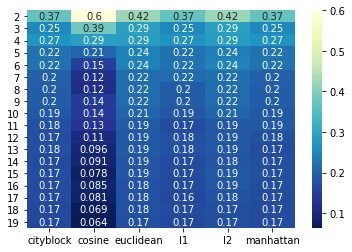

In [67]:
# Grid Search
num_clusters = range(2, 20)
dist_measures = ['cityblock', 'cosine', 'euclidean', 'l1', 'l2', 'manhattan']
grid_search = pd.DataFrame(columns=dist_measures, index=num_clusters)

for i, num in enumerate(num_clusters):
    for j, measure in enumerate(dist_measures):

        kmeansModel = KMeans(init='random', n_clusters=num, n_init=10)
        kmeansModel.fit_predict(norm_data)
        clusterIDs = kmeansModel.labels_
        
        score = metrics.silhouette_score(norm_data, clusterIDs, metric=measure)
        
        grid_search.iloc[i, j] = score

grid_search = grid_search.astype(float)
sns.heatmap(grid_search, annot=True, cmap="YlGnBu_r")

In [70]:
## Kmeans k=2 

kmeansModel = KMeans(init='random', n_clusters=2, n_init=10)
kmeansModel.fit_predict(norm_data)
clusterIDs = kmeansModel.labels_


pca = PCA(n_components=2)
pca.fit(norm_data)
pca_pairs = pca.transform(norm_data)

[xpos,ypos] = [0,1]

clus1 = ColumnDataSource(dict(x=pca_pairs[clusterIDs==0,xpos], 
    y=pca_pairs[clusterIDs==0,ypos],
    name=np.array(providers_merged[clusterIDs==0]['Provider Name']),
    state=np.array(providers_merged[clusterIDs==0]['Provider State'])))
clus2 = ColumnDataSource(dict(x=pca_pairs[clusterIDs==1,xpos], 
    y=pca_pairs[clusterIDs==1,ypos],
    name=np.array(providers_merged[clusterIDs==1]['Provider Name']),
    state=np.array(providers_merged[clusterIDs==1]['Provider State'])))

TOOLTIPS = [("Name", "@name"), ("State", "@state") ]
p = figure(plot_width=900, plot_height=600, title="Kmeans Clustering k=2", toolbar_location="below", tooltips=TOOLTIPS)
p.circle( x='x', y = 'y', source=clus1, size=9, color="gold")
p.circle( x='x', y = 'y', source=clus2, size=9, color="crimson")
p.xaxis.axis_label = 'PCA 1'
p.yaxis.axis_label = 'PCA 2'

show(p)

print("Silhouette Score: ", metrics.silhouette_score(norm_data, clusterIDs, metric='cosine'))
print("PCA Explained Variance Ratio: " , pca.explained_variance_ratio_)

Silhouette Score:  0.6001293411863532
PCA Explained Variance Ratio:  [0.71955923 0.16424342]


In [25]:
full_list['id'] = full_list.index
providers_long = pd.wide_to_long(full_list, ['Total Discharges',
                                             'Average Charges',
                                             'Average Payments',
                                             'Average Medicare Payment',
                                             'Average Non Medicare Payment'], i='id' , j='Year', sep='-')
providers_long

Provider State   Provider City  \
id     Year                                  
10001  2011             AL          DOTHAN   
10005  2011             AL            BOAZ   
10006  2011             AL        FLORENCE   
10007  2011             AL             OPP   
10008  2011             AL         LUVERNE   
10011  2011             AL      BIRMINGHAM   
10012  2011             AL      FORT PAYNE   
10016  2011             AL       ALABASTER   
10019  2011             AL       SHEFFIELD   
10021  2011             AL           OZARK   
10022  2011             AL          CENTRE   
10023  2011             AL      MONTGOMERY   
10024  2011             AL      MONTGOMERY   
10029  2011             AL         OPELIKA   
10032  2011             AL         WEDOWEE   
10033  2011             AL      BIRMINGHAM   
10034  2011             AL       TALLASSEE   
10035  2011             AL         CULLMAN   
10036  2011             AL       ANDALUSIA   
10038  2011             AL        ANNISTON   
10039  2011             AL      HUNTSVILLE   
10040  2011             AL         GADSDEN   
10044  2011             AL        HAMILTON   
10045  2011             AL         FAYETTE   
10046  2011             AL         GADSDEN   
10047  2011             AL       GEORGIANA   
10049  2011             AL      ENTERPRISE   
10052  2011             AL       DADEVILLE   
10055  2011             AL          DOTHAN   
10056  2011             AL      BIRMINGHAM   
...                    ...             ...   
670005 2016             TX        KINGWOOD   
670006 2016             TX          AUSTIN   
670008 2016             TX         WEBSTER   
670019 2016             TX         HOUSTON   
670023 2016             TX       MANSFIELD   
670024 2016             TX         CYPRESS   
670025 2016             TX           PLANO   
670031 2016             TX        PASADENA   
670034 2016             TX      ROUND ROCK   
670041 2016             TX      ROUND ROCK   
670043 2016             TX      CEDAR PARK   
670044 2016             TX        ROCKWALL   
670046 2016             TX      FORT WORTH   
670047 2016             TX         EL PASO   
670049 2016             TX          DALLAS   
670053 2016             TX      SUGAR LAND   
670054 2016             TX     SAN ANTONIO   
670055 2016             TX     SAN ANTONIO   
670056 2016             TX            KYLE   
670059 2016             TX   THE WOODLANDS   
670060 2016             TX       SUNNYVALE   
670061 2016             TX  CORPUS CHRISTI   
670067 2016             TX       ARLINGTON   
670068 2016             TX    FLOWER MOUND   
670069 2016             TX        MCKINNEY   
670071 2016             TX       ARLINGTON   
670073 2016             TX         ADDISON   
670075 2016             TX         HOUSTON   
670076 2016             TX         SHERMAN   
670077 2016             TX         HOUSTON   

                             Provider Street Address  Provider Zip Code  \
id     Year                                                               
10001  2011                   1108 ROSS CLARK CIRCLE              36301   
10005  2011               2505 U S HIGHWAY 431 NORTH              35957   
10006  2011                       205 MARENGO STREET              35631   
10007  2011                            702 N MAIN ST              36467   
10008  2011                      101 HOSPITAL CIRCLE              36049   
10011  2011               50 MEDICAL PARK EAST DRIVE              35235   
10012  2011                     200 MED CENTER DRIVE              35968   
10016  2011                  1000 FIRST STREET NORTH              35007   
10019  2011             1300 SOUTH MONTGOMERY AVENUE              35660   
10021  2011                         126 HOSPITAL AVE              36360   
10022  2011                         400 NORTHWOOD DR              35960   
10023  2011                2105 EAST SOUTH BOULEVARD              36116   
10024  2011                         1725 PINE STREET           

In [52]:
#get lat/long for providers
geolocs = pd.read_csv('GeocodeResults.csv', header=None)
geolocs = geolocs.set_index(0)
geolocs = geolocs.rename({1:'Address',
                          2:'Match',
                          3:'Match Type',
                          4:'Found Address',
                          5:'Interpolated Long/Lat',
                          6:'TIGER ID',
                          7:'Street Side'}, axis='columns')

lonlat = geolocs['Interpolated Long/Lat'].str.split(',', expand=True)
lonlat = lonlat.rename({0:'Longitude', 1:'Latitude'}, axis=1)
lonlat = lonlat.set_index(geolocs.index)
lonloat = lonlat.astype(float)

geodata = pd.concat([geolocs, lonlat], axis=1, join='inner')
geodata.drop(columns=['Interpolated Long/Lat', 'TIGER ID', 'Street Side'], inplace=True)
geodata['Longitude'] = geodata['Longitude'].astype(float)
geodata['Latitude'] = geodata['Latitude'].astype(float)
geodata.head()

Address     Match Match Type  \
0                                                                               
180013         250 PARK STREET, BOWLING GREEN, KY, 42101     Match      Exact   
180012  913 NORTH DIXIE AVENUE, ELIZABETHTOWN, KY, 42701  No_Match        NaN   
40062             7301 ROGERS AVE, FORT SMITH, AR, 72917  No_Match        NaN   
40069     1520 N DIVISION STREET, BLYTHEVILLE, AR, 72315     Match  Non_Exact   
180017        1301 NORTH RACE STREET, GLASGOW, KY, 42141     Match      Exact   

                                     Found Address  Longitude   Latitude  
0                                                                         
180013       250 PARK ST, BOWLING GREEN, KY, 42101 -86.432540  36.994846  
180012                                         NaN        NaN        NaN  
40062                                          NaN        NaN        NaN  
40069   1520 S DIVISION ST, BLYTHEVILLE, AR, 72315 -89.918686  35.910200  
180017          1301 N RACE ST, GLASGOW, KY, 42141 -85.903430  37.010834

In [53]:
complete_geo = geodata.dropna()

In [55]:
from folium.plugins import MarkerCluster
 
USA_COORDINATES = (37.0902, -95.7129)

  
# create empty map zoomed in on center of USA
m = folium.Map(location=USA_COORDINATES, zoom_start=3.5)

mc = MarkerCluster()
 
# add a marker for every record in the filtered data, use a clustered view
for r in complete_geo.itertuples():

    mc.add_child(folium.Marker(
        location=[ r.Latitude, r.Longitude],
#        popup=folium.Popup("Lets try quotes", parse_html=True),
        icon=folium.Icon(color='green')
    ))
        
        
m.add_child(mc)

display(m)


In [69]:
## reformat to try to determine other address -- not working
found = complete_geo.index
found

null_idx = pd.Series(pd.isnull(geodata).any(1))#.nonzero()[0]
not_found = pd.DataFrame(geodata[null_idx])
not_found.drop(columns=['Match', 'Match Type', 'Found Address', 'Longitude', 'Latitude'], inplace=True)
not_found_addrs = not_found['Address'].str.split(',', expand=True)
not_found_addrs.drop(columns=[4, 5, 6], inplace=True)
not_found_addrs[1] = not_found_addrs[1].str.strip()
not_found_addrs[2] = not_found_addrs[2].str.strip()
not_found_addrs[3] = not_found_addrs[3].str.strip()
not_found_addrs[0] = np.nan
not_found_addrs[1] = np.nan
not_found_addrs[2] = np.nan
not_found_addrs.head()
#not_found_addrs.to_csv('still_missing1.csv', header=False)

In [29]:

  # create empty map zoomed in on San Francisco
m = folium.Map(location=USA_COORDINATES, zoom_start=3.5)
lats = []
lons = []
mag = np.random.randn(len(complete_geo))


for r in complete_geo.itertuples():
    lats.append(r.Latitude)
    lons.append(r.Longitude)

m.add_child(plugins.HeatMap(zip(lats, lons, mag), radius = 10))
m

In [70]:
full_list.head()

Provider Name     Provider Street Address  \
Provider Id                                                                 
10001        SOUTHEAST ALABAMA MEDICAL CENTER      1108 ROSS CLARK CIRCLE   
10005           MARSHALL MEDICAL CENTER SOUTH  2505 U S HIGHWAY 431 NORTH   
10006          ELIZA COFFEE MEMORIAL HOSPITAL          205 MARENGO STREET   
10007                MIZELL MEMORIAL HOSPITAL               702 N MAIN ST   
10008             CRENSHAW COMMUNITY HOSPITAL         101 HOSPITAL CIRCLE   

            Provider City Provider State  Provider Zip Code  \
Provider Id                                                   
10001              DOTHAN             AL              36301   
10005                BOAZ             AL              35957   
10006            FLORENCE             AL              35631   
10007                 OPP             AL              36467   
10008             LUVERNE             AL              36049   

             Total Discharges-2011  Average Charges-2011  \
Provider Id                                                
10001                         5405          32857.012395   
10005                         1419          16451.170543   
10006                         3901          33464.126890   
10007                          603          10857.281924   
10008                          161          15234.732918   

             Average Payments-2011  Average Medicare Payment-2011  \
Provider Id                                                         
10001                  8176.438668                    7112.044958   
10005                  6902.408739                    5832.492600   
10006                  7537.756216                    6480.229428   
10007                  4405.252073                    3602.520730   
10008                  5765.062112                    4810.397516   

             Average Non Medicare Payment-2011  ...    Average Charges-2015  \
Provider Id                                     ...                           
10001                              1064.393710  ...            38255.160503   
10005                              1069.916138  ...            16715.333523   
10006                              1057.526788  ...            40858.429765   
10007                               802.731343  ...            11698.370397   
10008                               954.664596  ...            15521.834545   

             Average Payments-2015  Average Medicare Payment-2015  \
Provider Id                                                         
10001                  8569.073038                    7437.702630   
10005                  7066.508413                    5852.408952   
10006                  8308.655104                    7057.090193   
10007                  5176.299310                    4320.415941   
10008                  6207.136061                    5173.802424   

             Average Non Medicare Payment-2015  Total Discharges-2016  \
Provider Id                                                             
10001                              1131.370408                 7448.0   
10005                              1214.099461                 2908.0   
10006                              1251.564910                 4916.0   
10007                               855.883368                  410.0   
10008                              1033.333636                   38.0   

             Average Charges-2016  Average Payments-2016  \
Provider Id                                                
10001                42533.408046            8898.150373   
10005                16664.336472            6946.778999   
10006                39980.171428            8461.748611   
10007                12209.880732            5453.564146   
10008                13784.080000            4702.871579   

             Average Medicare Payment-2016  Average Non Medicare Payment-2016  \
Provider Id                                                                     
10001       

In [73]:
provlatlon = complete_geo[['Latitude', 'Longitude']]
provlatlon.head()

Latitude  Longitude
0                           
180013  36.994846 -86.432540
40069   35.910200 -89.918686
180017  37.010834 -85.903430
180016  38.210457 -85.236070
110143  33.858223 -84.600500

In [74]:
full_w_gloc = pd.merge(full_list, provlatlon, right_index=True, left_index=True)
full_w_gloc

Provider Name  \
10007                            MIZELL MEMORIAL HOSPITAL   
10019                      HELEN KELLER MEMORIAL HOSPITAL   
10021                                 DALE MEDICAL CENTER   
10022                             CHEROKEE MEDICAL CENTER   
10024                       JACKSON HOSPITAL & CLINIC INC   
10029                         EAST ALABAMA MEDICAL CENTER   
10032                                    WEDOWEE HOSPITAL   
10034                              COMMUNITY HOSPITAL INC   
10036                         ANDALUSIA REGIONAL HOSPITAL   
10038                      STRINGFELLOW MEMORIAL HOSPITAL   
10040                     GADSDEN REGIONAL MEDICAL CENTER   
10044                      MARION REGIONAL MEDICAL CENTER   
10045                              FAYETTE MEDICAL CENTER   
10046                   RIVERVIEW REGIONAL MEDICAL CENTER   
10049                           MEDICAL CENTER ENTERPRISE   
10052                      LAKE MARTIN COMMUNITY HOSPITAL   
10055                                    FLOWERS HOSPITAL   
10058                                 BIBB MEDICAL CENTER   
10059                             LAWRENCE MEDICAL CENTER   
10062                            WIREGRASS MEDICAL CENTER   
10069                              MEDICAL CENTER BARBOUR   
10073                                CLAY COUNTY HOSPITAL   
10078           NORTHEAST ALABAMA REGIONAL MEDICAL CENTER   
10083               SOUTH BALDWIN REGIONAL MEDICAL CENTER   
10087          UNIVERSITY OF SOUTH ALABAMA MEDICAL CENTER   
10092                       D C H REGIONAL MEDICAL CENTER   
10097                           ELMORE COMMUNITY HOSPITAL   
10099                      D W MCMILLAN MEMORIAL HOSPITAL   
10100                                     THOMAS HOSPITAL   
10101                     CITIZENS BAPTIST MEDICAL CENTER   
...                                                   ...   
530008                               SAGEWEST HEALTH CARE   
530012                             WYOMING MEDICAL CENTER   
530014                   CHEYENNE REGIONAL MEDICAL CENTER   
530015                            ST JOHNS MEDICAL CENTER   
530032                         EVANSTON REGIONAL HOSPITAL   
670005        MEMORIAL HERMANN SURGICAL HOSPITAL KINGWOOD   
670008                       HOUSTON PHYSICIANS' HOSPITAL   
670019                        UNIVERSITY GENERAL HOSPITAL   
670023                 METHODIST MANSFIELD MEDICAL CENTER   
670025                    THE HEART HOSPITAL BAYLOR PLANO   
670041                    SETON MEDICAL CENTER WILLIAMSON   
670043                 CEDAR PARK REGIONAL MEDICAL CENTER   
670044        TEXAS HEALTH PRESBYTERIAN HOSPITAL ROCKWALL   
670046                    USMD HOSPITAL  AT FORT WORTH LP   
670047              SIERRA PROVIDENCE EAST MEDICAL CENTER   
670049                  NORTH CENTRAL SURGICAL CENTER LLP   
670053                      ST LUKE'S SUGAR LAND HOSPITAL   
670054        FOUNDATION SURGICAL HOSPITAL OF SAN ANTONIO   
670055                       METHODIST STONE OAK HOSPITAL   
670056                          SETON MEDICAL CENTER HAYS   
670059                         ST LUKES LAKESIDE HOSPITAL   
670060    BAYLOR SCOTT AND WHITE MEDICAL CENTER SUNNYVALE   
670061                      SOUTH TEXAS SURGICAL HOSPITAL   
670067  BAYLOR ORTHOPEDIC AND SPINE HOSPITAL AT ARLINGTON   
670068    TEXAS HEALTH PRESBYTERIAN HOSPITAL FLOWER MOUND   
670069                        METHODIST MCKINNEY HOSPITAL   
670071   TEXAS HEALTH HEART & VASCULAR HOSPITAL ARLINGTON   
670073                     METHODIST HOSPITAL FOR SURGERY   
670075                  ST LUKE'S HOSPITAL AT THE VINTAGE   
670076  BAYLOR SCOTT AND WHITE SURGICAL HOSPITAL AT SH...   

                        Provider Street Address   Provider City  \
10007                             702 N MAIN ST             OPP   
10019              1300 SOUTH MONTGOMERY AVENUE       SHEFFIELD   
10021                          126 HOSPITAL AVE           OZ

In [78]:
m = folium.Map(location=USA_COORDINATES, zoom_start=3.5)
lats = []
lons = []
mag = []


for r in full_w_gloc.itertuples():
    lats.append(r.Latitude)
    lons.append(r.Longitude)
    mag.append(r._32)

m.add_child(plugins.HeatMap(zip(lats, lons, mag), radius = 10))
m

In [77]:
for r in full_w_gloc.itertuples():
    print(r._32)

12209.880731707317
23704.90830397585
16175.599347258485
19025.557602739726
47210.93490501844
20789.02701821862
13055.73
11234.557014925373
31945.784287317623
47240.431980440095
113750.20345544553
18107.09424050633
18881.21057823129
52399.7126783426
58387.67626465662
6154.837021276596
65979.60507552084
6895.655000000001
15794.093237410072
14459.392145454545
16367.737638376386
7823.873141361257
51835.45997135419
62851.71934976044
27291.556344339624
37517.635694604935
4827.974422110552
10057.490321637428
29006.921360734235
21310.78386363636
77131.33617952756
15565.760072463765
31481.730415937534
40618.24346497765
13921.987471264369
15611.938085106385
96596.72867036678
28651.863696599827
10288.824595103575
32239.34256475047
48241.8819375
27114.518796791446
31013.054301242235
16241.072565789475
62501.8301098901
39684.95390804598
50866.74324257426
114527.54533073927
54944.50784615384
81319.10216535433
46706.68714285715
97189.75455158636
44599.27005880319
70146.88919528949
48496.28972202422
4

35125.65789955888
30466.08295967538
27264.89041632652
68095.50001834863
29512.270021095108
36395.138974817826
54694.329556128825
98088.07878932756
19827.71340153453
28593.464054172135
55748.26274275195
30974.2437247924
22667.843481579814
36297.96976886964
56548.50019120133
31696.020813851286
32471.43066216935
40059.351438574166
56121.428280926375
32957.32957336109
43758.43855463224
72855.24917225952
35447.720760942764
20491.992358519423
32094.868019370457
25244.01161231884
15029.950238095238
19726.261608187135
38700.12227272727
34455.979632892806
18049.814156250002
49820.158547854786
26983.900736196312
27275.410767987058
51824.07447130882
31581.792961672476
103845.44113440972
34489.847580317204
18215.058043478264
24337.884813039305
27150.976232294623
21313.038854961833
110805.8716141797
24263.592714901337
33160.3722675737
23007.88630952381
21087.92734939759
44962.785186295514
26086.865254658387
35248.78552750226
46356.85353406098
47335.00092535472
50504.58327197149
27825.039489559163
8